# Lab 5 - Using link functions to create generalized linear models

## Import packages

In [307]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

from cmdstanpy import CmdStanModel

## Load and analyze data

In [308]:
airline_df = pd.read_csv('Airline_data.csv')
airline_df.head()

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
0,1976,24,734,3863.0
1,1977,25,516,4300.0
2,1978,31,754,5027.0
3,1979,31,877,5481.0
4,1980,22,814,5814.0


In [309]:
airline_df["Miles flown [100 bln miles]"] = airline_df["Miles flown [100 mln miles]"] / 1000
airline_df.head()

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles],Miles flown [100 bln miles]
0,1976,24,734,3863.0,3.863
1,1977,25,516,4300.0,4.300
2,1978,31,754,5027.0,5.027
3,1979,31,877,5481.0,5.481
4,1980,22,814,5814.0,5.814


In [310]:
alpha_mu = np.log(airline_df['Fatal accidents'].mean())
alpha_sig = np.log(airline_df['Fatal accidents'].std())
print(f"Natural logarithm of the mean of 'Fatal accident': {alpha_mu}")
print(f"Natural logarithm of the standard deviation of 'Fatal accident': {alpha_sig}")
airline_df.describe()

Natural logarithm of the mean of 'Fatal accident': 3.169685580677429
Natural logarithm of the standard deviation of 'Fatal accident': 1.549545393270572


,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles],Miles flown [100 bln miles]
count,10.00000,10.000000,10.000000,10.000000,10.000000
mean,1980.50000,23.800000,691.900000,5715.800000,5.715800
std,3.02765,4.709329,252.389228,1117.767795,1.117768
min,1976.00000,16.000000,223.000000,3863.000000,3.863000
25%,1978.25000,21.250000,570.500000,5140.500000,5.140500
50%,1980.50000,23.000000,759.000000,5845.500000,5.845500
75%,1982.75000,25.750000,812.750000,6175.500000,6.175500
max,1985.00000,31.000000,1066.000000,7433.000000,7.433000


In [311]:
N = len(airline_df)
R = 1000
seed = 29042020

## Prior predictive model

In [312]:
model_ppc1 = CmdStanModel(stan_file='prior1.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [313]:
theta_mu, theta_sig = 0.05, 0.005

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |███▋      | 00:00 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


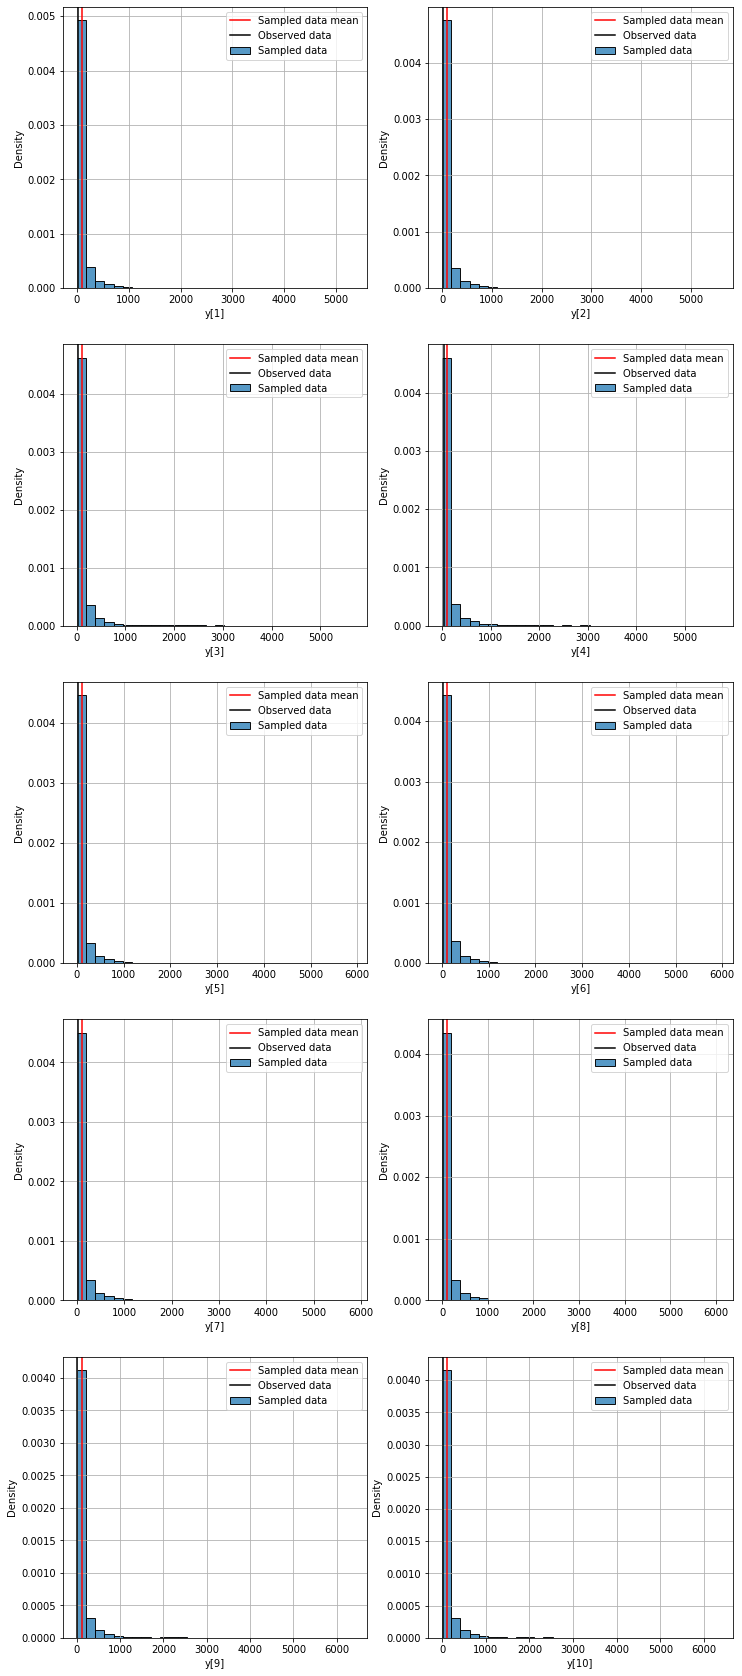

In [314]:
data = {"N": N, "n_i": airline_df["Miles flown [100 bln miles]"].values, "alpha_mu": alpha_mu, "alpha_sig": alpha_sig, "theta_mu": theta_mu, "theta_sig": theta_sig}
sim1 = model_ppc1.sample(data=data, iter_sampling=R, seed=seed)
sim1_pd = sim1.draws_pd()

_, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 30))
ax = ax.flatten()

for i in range(N):
    sns.histplot(data=sim1_pd, x=sim1_pd[f"y[{i + 1}]"], stat="density", ax=ax[i], bins=30, label="Sampled data")
    ax[i].axvline(sim1_pd[f"y[{i + 1}]"].mean(), color="red", label="Sampled data mean")
    ax[i].axvline(airline_df["Fatal accidents"][i], color="black", label="Observed data")
    ax[i].grid()
    ax[i].legend()

plt.show()

***Prior distribution tries to model the data, however it is quite visible that it lacks some posterior information.***

## Posterior predictive distribution

In [315]:
model_fit1 = CmdStanModel(stan_file='posterior1.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status



chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


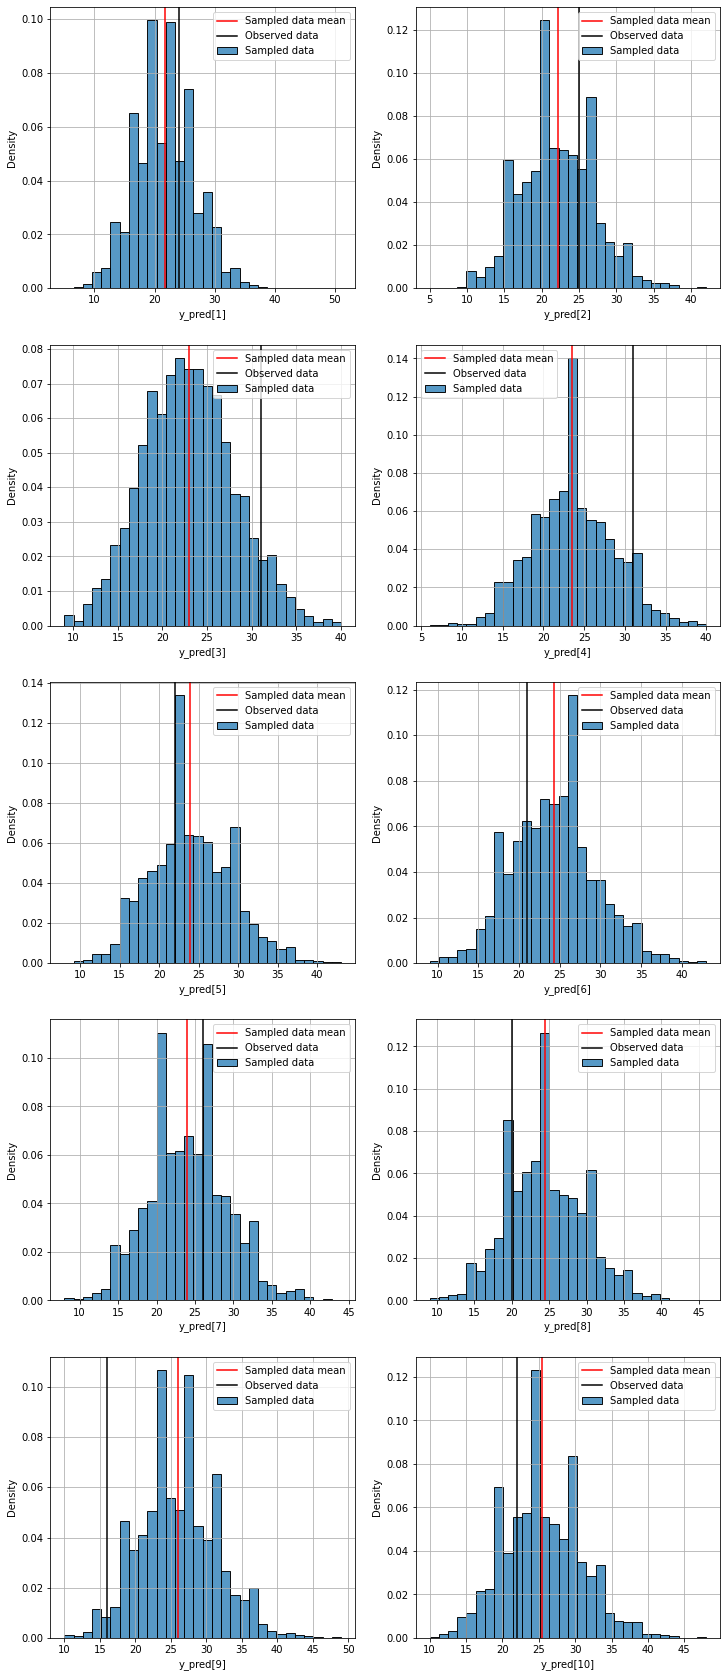

In [316]:
data = {"N": N, "n_i": airline_df["Miles flown [100 bln miles]"].values, "y": airline_df["Fatal accidents"].values, "alpha_mu": alpha_mu, "alpha_sig": alpha_sig,
"theta_mu": theta_mu, "theta_sig": theta_sig}
fit1 = model_fit1.sample(data=data, iter_sampling=R, seed=seed)
fit1_pd = fit1.draws_pd()

_, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 30))
ax = ax.flatten()

for i in range(N):
    sns.histplot(data=fit1_pd, x=fit1_pd[f"y_pred[{i + 1}]"], stat="density", bins=30, ax=ax[i], label="Sampled data")
    ax[i].axvline(fit1_pd[f"y_pred[{i + 1}]"].mean(), color="red", label="Sampled data mean")
    ax[i].axvline(airline_df["Fatal accidents"][i], color="black", label="Observed data")
    ax[i].grid()
    ax[i].legend()

plt.show()

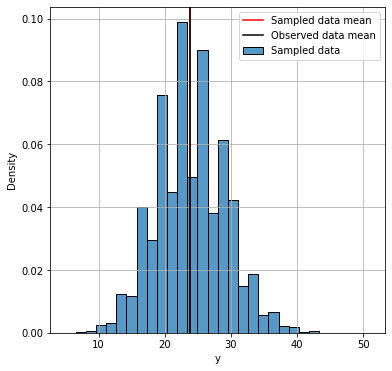

In [317]:
plt.figure(figsize=(6, 6))
data = []

for i in range(N):
    data.append(fit1_pd[f"y_pred[{i + 1}]"])

data = pd.concat(data)
sns.histplot(data=data, stat="density", bins=30, label="Sampled data")
plt.axvline(data.mean(), color="red", label="Sampled data mean")
plt.axvline(airline_df["Fatal accidents"].mean(), color="black", label="Observed data mean")
plt.grid()
plt.legend()
plt.xlabel("y")
plt.show()

***Posterior distribution models the data much better, however it uses one common parameter $\alpha$ for the data for all the years. Therefore, the model tries to improve the fitting among all the years simultaneously, not for each year independently. Then when the data for one year is fitted perfectly, the data for another year can get worse. It should be changed so that each year has their own parameter set. Nevertheless, on the common histogram it is clearly displayed that the model fits the overall data pretty well.***

## Model improvement

In [318]:
model_ppc2 = CmdStanModel(stan_file='prior2.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [319]:
theta_mu, theta_sig = 0.005, 0.0005 

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status
chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


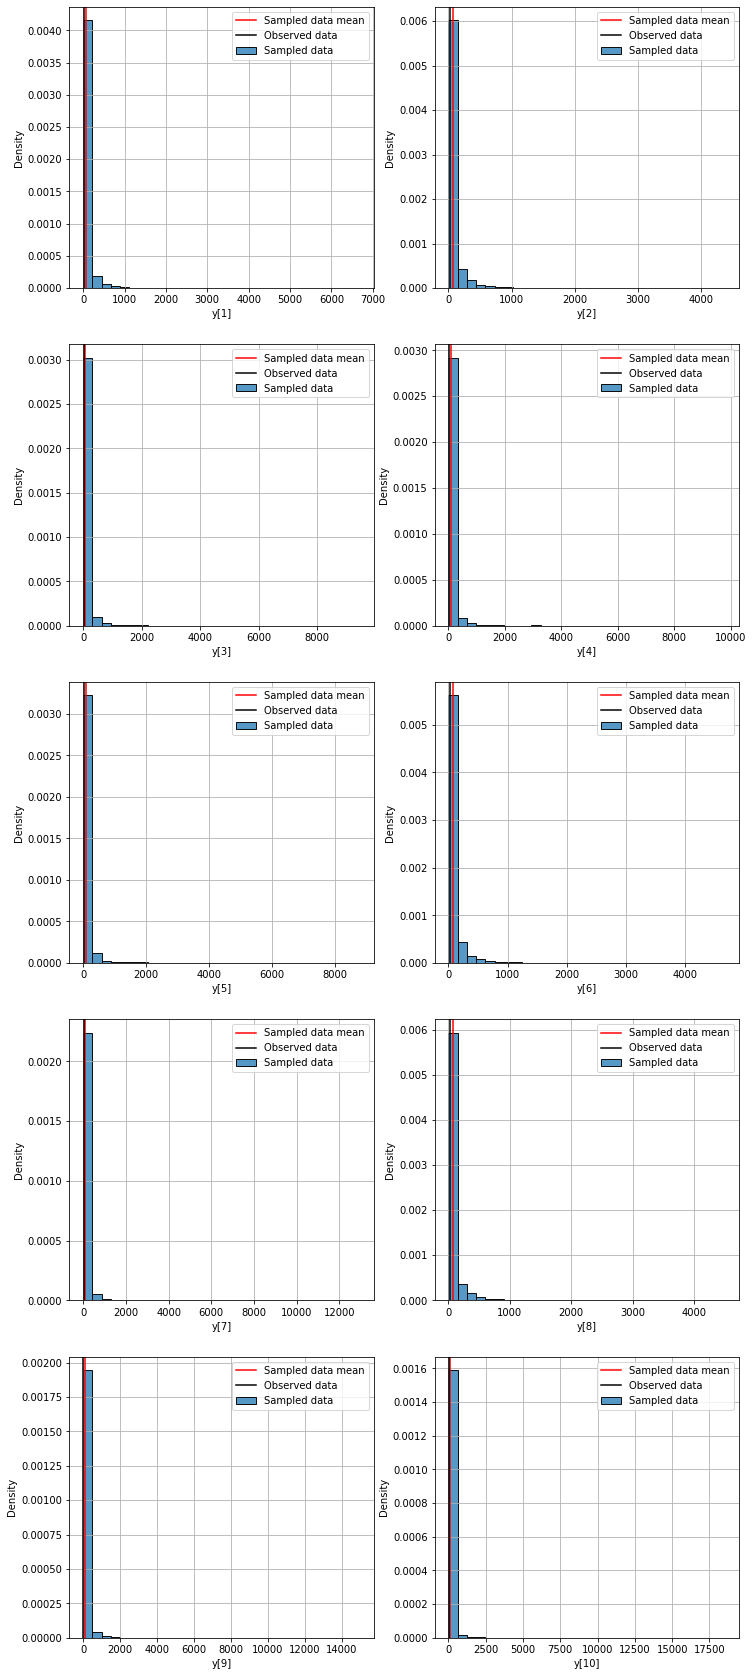

In [320]:
data = {"N": N, "n_i": airline_df["Miles flown [100 bln miles]"].values, "y": airline_df["Fatal accidents"].values, "alpha_mu": alpha_mu, "alpha_sig": alpha_sig,
"theta_mu": theta_mu, "theta_sig": theta_sig}
sim2 = model_ppc2.sample(data=data, iter_sampling=R, seed=seed)
sim2_pd = sim2.draws_pd()

_, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 30))
ax = ax.flatten()

for i in range(N):
    sns.histplot(data=sim2_pd, x=sim2_pd[f"y[{i + 1}]"], stat="density", bins=30, ax=ax[i], label="Sampled data")
    ax[i].axvline(sim2_pd[f"y[{i + 1}]"].mean(), color="red", label="Sampled data mean")
    ax[i].axvline(airline_df["Fatal accidents"][i], color="black", label="Observed data")
    ax[i].grid()
    ax[i].legend()

plt.show()

***Prior distribution tries to model, however it is quite visible that it lacks some posterior information. Nevertheless, using independent parameters $\alpha_i$ has improved the fitting.***

In [321]:
model_fit2 = CmdStanModel(stan_file='posterior2.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |▉         | 00:01 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:02 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:02 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:02 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)





chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)




chain 1 |███████▋  | 00:03 Iteration: 1400 / 2000 [ 70%]  (Sampling)



chain 1 |████████▋ | 00:03 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████▌| 00:03 Iteration: 1800 / 2000

INFO:cmdstanpy:CmdStan done processing.


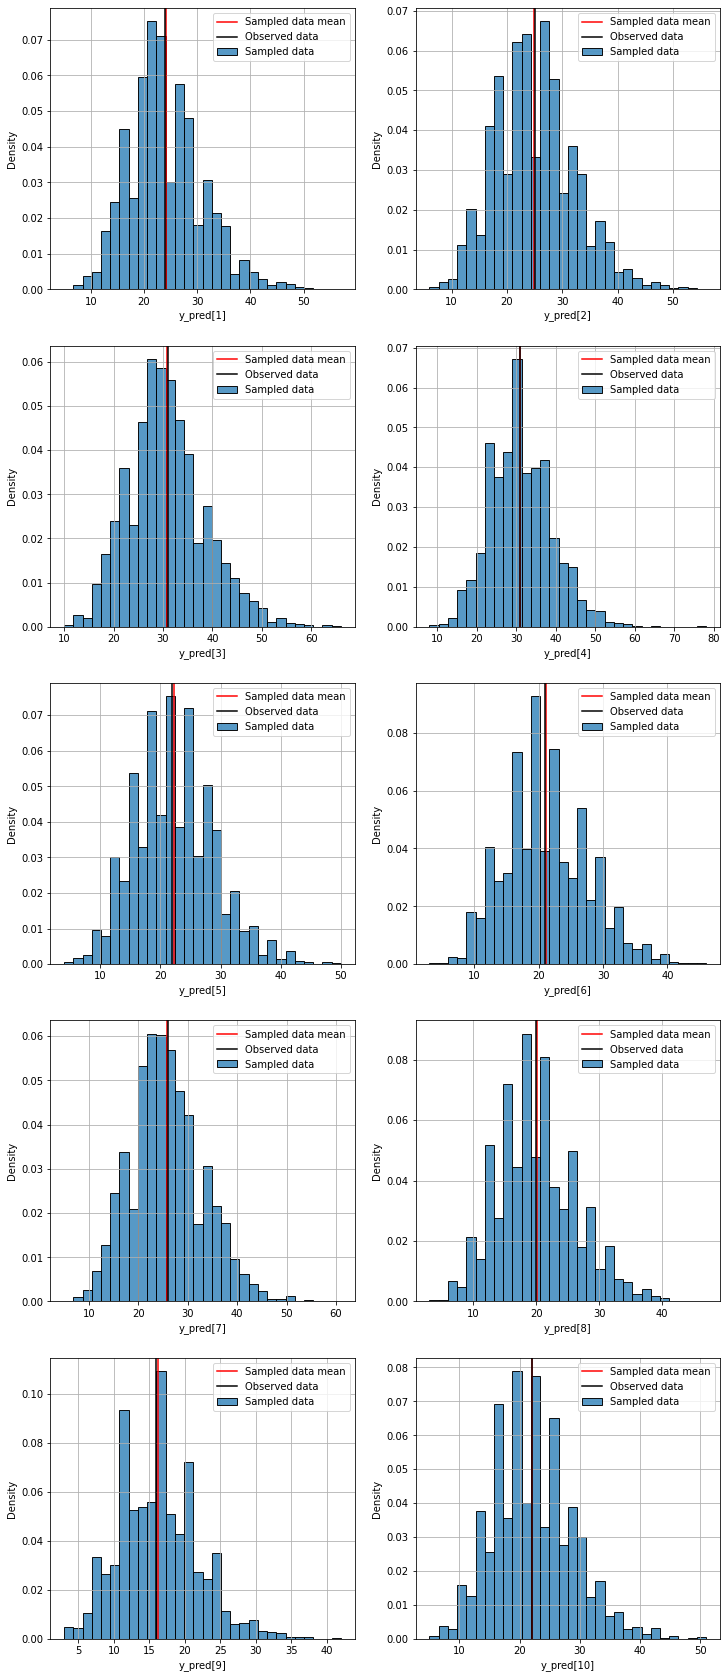

In [322]:
data = {"N": N, "n_i": airline_df["Miles flown [100 bln miles]"].values, "y": airline_df["Fatal accidents"].values, "alpha_mu": alpha_mu, "alpha_sig": alpha_sig,
"theta_mu": theta_mu, "theta_sig": theta_sig}
fit2 = model_fit2.sample(data=data, iter_sampling=R, seed=seed)
fit2_pd = fit2.draws_pd()

_, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 30))
ax = ax.flatten()

for i in range(N):
    sns.histplot(data=fit2_pd, x=fit2_pd[f"y_pred[{i + 1}]"], stat="density", bins=30, ax=ax[i], label="Sampled data")
    ax[i].axvline(fit2_pd[f"y_pred[{i + 1}]"].mean(), color="red", label="Sampled data mean")
    ax[i].axvline(airline_df["Fatal accidents"][i], color="black", label="Observed data")
    ax[i].grid()
    ax[i].legend()

plt.show()

***After tuning parameters $\alpha_i$ independently for each year, the posterior distribution fits the really well.***